## Analyse Single Transmon qubit using pyEPR
#### We use QISKIT METAL along with pyEPR 
#### EPR: Energy Participation Ratio: the ledger book of energy deposition that changes Hamiltonian

In [1]:
import pyEPR as epr
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import Dict, Headings, MetalGUI
from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

#### Start the GUI for the designing

In [2]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'
gui =MetalGUI(design)

#### Creating One Transmon Qubit

In [3]:
design.delete_all_components()
q1=TransmonPocket(design, 'Q1', 
                  options=dict(pad_width='425 um', pocket_height='650 um', 
                               connection_pads=dict(readout=dict(loc_w=+1, loc_H=+1, pad_width='200 um'))))
gui.rebuild()
gui.autoscale()

#### Finite Element Eigenmode Analysis 

In [4]:
eig_qb=EPRanalysis(design,"hfss")

In [5]:
hfss=eig_qb.sim.renderer

#### Opens ANSYS if closed else create a new project and 
#### finally connect to this notebook

In [6]:
# If "hfss.start()" fails then do it manually as bellow 
# Select only one line from below 
#
#
# hfss.open_ansys()                             # Opens ANSYS EM as installed
# hfss.open_ansys(path_var='ANSYSEM_ROOT211')
# hfss.open_ansys(path='D:\\Program Files\\AnsysEM\\AnsysEM20.2\\Win64')

In [7]:
# Then
#
# hfss.new_ansys_project()
# hfss.connect_ansys('D:\\Users\Abhijit Bhattacharyy\Documents\ANSYS_EM\\', 'Project1')

In [8]:
hfss.start()

INFO 02:03PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:03PM [load_ansys_project]: 	Opened Ansys App
INFO 02:03PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 02:03PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/Users/Abhijit Bhattacharyy/Documents/ANSYS_EM/
	Project:   Project2
INFO 02:03PM [connect_design]: No active design found (or error getting active design).
INFO 02:03PM [connect]: 	 Connected to project "Project2". No design detected


True

In [9]:
# Create and activate eigenmode design called "TransmonQubit"
hfss.activate_ansys_design("TransmonQubit", 'eigenmode')

02:04PM 04s WARNING [activate_ansys_design]: The design_name=TransmonQubit was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 02:04PM [connect_design]: 	Opened active design
	Design:    TransmonQubit [Solution type: Eigenmode]
WARNING 02:04PM [connect_setup]: 	No design setup detected.
WARNING 02:04PM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:04PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [10]:
hfss.render_design(['Q1'],[])

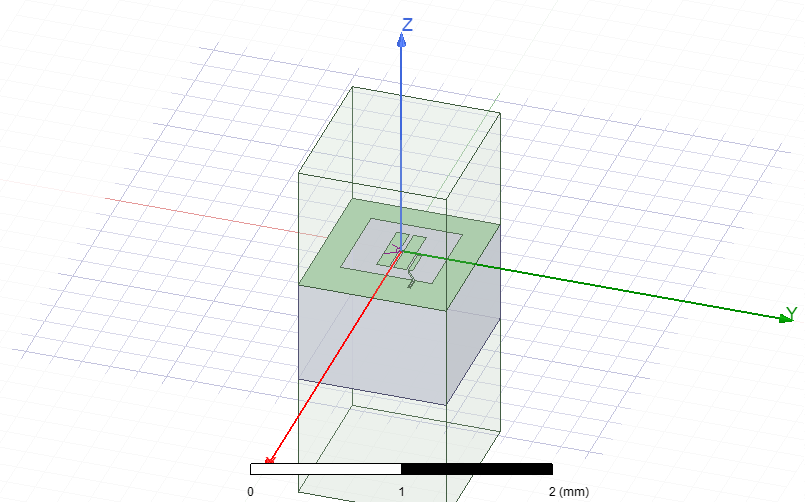

WindowsPath('D:/Qiskit_Metals/TIFR/School/SingleTransistor/ansys.png')

In [11]:
hfss.save_screenshot()

In [12]:
# Set convergence parameters and unction properties in Ansys design and run analysis
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 10
print(f"""
Number of eigenmodes to find   = {setup.n_modes} 
Number of simulation passes    = {setup.passes} 
Convergence frequency max delta percent difference = {setup.delta_f}
""")
pinfo = hfss.pinfo 
pinfo.design.set_variable('Lj', '10 nH')
pinfo.design.set_variable('Cj', '0 pF')
setup.analyze()

INFO 02:04PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find   = 1 
Number of simulation passes    = 10 
Convergence frequency max delta percent difference = 0.1



In [13]:
# One may plot convergences
eig_qb.sim.convergence_t, eig_qb.sim.convergence_f,_ = hfss.get_convergences() 
eig_qb.sim.plot_convergences() 

02:08PM 51s INFO [get_f_convergence]: Saved convergences to D:\Qiskit_Metals\TIFR\School\SingleTransistor\hfss_eig_f_convergence.csv


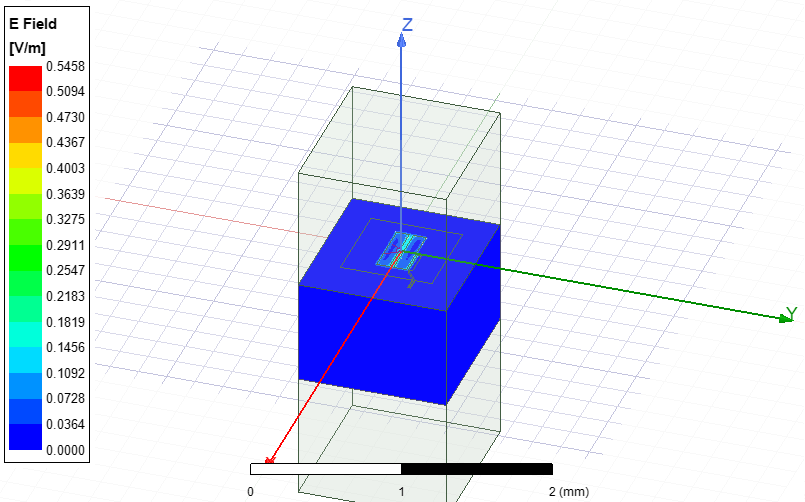

WindowsPath('D:/Qiskit_Metals/TIFR/School/SingleTransistor/ansys.png')

In [14]:
# Plot E-Field on the CHIP surface 
# Check the name of the E-Field mapping image in the ANSYS GUI 
# In this case it is written as "Mag_E1"

hfss.modeler._modeler.ShowWindow() 
hfss.plot_fields('main') 
hfss.save_screenshot() 

In [15]:
# For the next set of analysis, let us remove the Electric field mapping image
hfss.plot_ansys_delete(['Mag_E1'])

02:09PM 05s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [16]:
pinfo = hfss.pinfo
pinfo.junctions['jj']={'Lj_variable':'Lj', 'rect':'JJ_rect_Lj_Q1_rect_jj',
                        'line':'JJ_Lj_Q1_rect_jj_', 'Cjj_variable':'Cj'}
pinfo.validate_junction_info() # Valid names of variables are verified
pinfo.dissipative['dielectrics_bulk'] = ['main']  # Dissipative elements: specify

In [17]:
# Compute microwave analysis on eigenmode solutions 
eprd=epr.DistributedAnalysis(pinfo)

Design "TransmonQubit" info:
	# eigenmodes    1
	# variations    1


In [18]:
# Let us find electric and magnetic energy stored in the substrate and system as a whole
ℰ_elec = eprd.calc_energy_electric()
ℰ_elec_substrate = eprd.calc_energy_electric(None, 'main')
ℰ_mag = eprd.calc_energy_magnetic()

print(f"""
ℰ_elec_all                     = {ℰ_elec}
ℰ_elec_substrate               = {ℰ_elec_substrate}
EPR of substrate               = {ℰ_elec_substrate / ℰ_elec * 100:0.1f}
ℰ_mag                          = {ℰ_mag}
""")


ℰ_elec_all                     = 1.4989054843814e-24
ℰ_elec_substrate               = 1.38049480832505e-24
EPR of substrate               = 92.1
ℰ_mag                          = 3.22109008557658e-26



In [19]:
# Perform EPR analysis for all modes and variations 
eprd.do_EPR_analysis() 

# (a) Build Hamiltonian spectrum post-analysis on MW solutions usign EPR 
epra = epr.QuantumAnalysis(eprd.data_filename)
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 7)


# (b) Report Solved Results
swp_variable = 'Lj' # suppose we swept an optimetric analysis vs inductance Lj_alice
epra.plot_hamiltonian_results(swp_variable = swp_variable)
epra.report_results(swp_variable = swp_variable, numeric = True)


Variation 0  [1/1]

  Mode 0 at 6.36 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.9%  7.495e-25 1.611e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 96.90%
	jj              0.994455  (+)        0.0317995
		(U_tot_cap-U_tot_ind)/mean=0.77%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9210019061974289


WARNING 02:09PM [__init__]: <p>Error: <class 'IndexError'></p>
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project2\TransmonQubit\2024-02-05 14-09-22.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.015776
dtype: float64

Pm_norm idx =
     jj
0  True
*** P (participation matrix, not normlz.)
         jj
0  0.963807

*** S (sign-bit matrix)
   s_jj
0     1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       297

*** Chi matrix ND (MHz) 
       329

*** Frequencies O1 PT (MHz)
0    6067.053834
dtype: float64

*** Frequencies ND (MHz)
0    6051.884305
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj       10
0   6051.88

#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0
Lj         
10 0  328.7

In [20]:
gui.main_window.close()
eig_qb.sim.close()